## BITS WILP
# Data Mining ISZC415

|Name|RollNumber|Contribution|
|---|---|---|
|Anupam Srivastava|2018HT13250|100%|
|Mohd Shoeb|2020MT12084|100%|
|Manvir Kaur|2020MT12411|100%|

## Table of contents:

1. Data selection
2. First look
3. Data pre-processing and exploration
    1. Numerical attributes
        1. Normalization using z-score
        2. Outlier removal using z-score
        3. Cluster analysis of numerical features using k-means
        4. Observations
    2. Categorical attributes
        1. Outlier removal
        1. Association rule mining based on Apriori
        2. Observations
4. Model selection
    1. Converting categorical features to numerical
    2. Using Naive-Bayes to model data
5. Conclusion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

### Data selection

In [2]:
fileName = "healthcare-dataset-stroke-data.csv"
df = pd.read_csv(fileName)

### First look

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.shape

(5110, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


### Data pre-processing and exploration

We want to analyse the features that are good predictory for having a stroke. Thus, "stroke" is the
target variable.

The data consists of both numerical and categorical features. From the data we can see that bmi is
null for certain rows. Also, id is not a feature hence can be dropped.

In [6]:
df = df.drop(columns="id")

In [7]:
target = "stroke"
numerical = list()
categorical = list()
for col in df.columns:
    if col == target:
        continue
    if len(df[col].value_counts()) > 5:
        numerical.append(col)
    else:
        categorical.append(col)

print("Numerical features:", numerical)
print("Categorical features:", categorical)
print("Target:", target)

Numerical features: ['age', 'avg_glucose_level', 'bmi']
Categorical features: ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
Target: stroke


#### Numerical attributes

In [8]:
df[numerical].describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


All numerical attributes are of ratio type.

We will replace null bmi values with median and then check of correlation between them to find out
if all the numerical attributes are independent or not.

In [9]:
df["bmi"].fillna(df["bmi"].median(), inplace= True)

In [10]:
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

                        age  avg_glucose_level       bmi
age                1.000000           0.238171  0.324296
avg_glucose_level  0.238171           1.000000  0.166876
bmi                0.324296           0.166876  1.000000


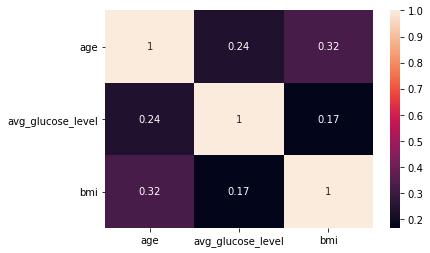

In [11]:
corr_matrix = df[numerical].corr()
print(corr_matrix)
sns.heatmap(corr_matrix, annot=True)
plt.show()

From the correlation matrix we see that numerical features are mostly independent of each other.

Thus, we do not need to perform Principal Component Analysis for numerical features.

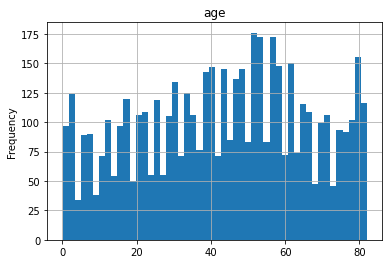

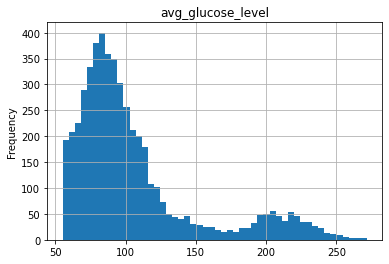

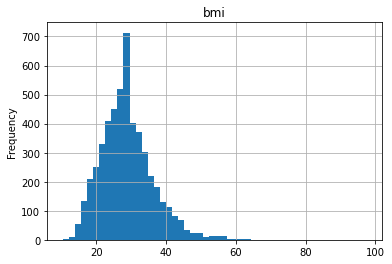

In [12]:
for col in numerical:
    df[col].plot(kind="hist", bins=50)
    plt.title(col)
    plt.grid()
    plt.show()

We can see that bmi is highly skewed to the right, and we should normalize it by removing any
outliers. We will do this my calculating z-score and removing any point with z-score > 3 or < -3 as
an outlier.

##### Data normalization using z-score

In [13]:
bmi_mean = df["bmi"].mean()
bmi_sd = df["bmi"].std()
bmi_z_score = list()
for i in df["bmi"]:
    z = (i - bmi_mean) / bmi_sd
    bmi_z_score.append(z)
df["bmi_z_score"] = bmi_z_score

age_mean = df["age"].mean()
age_sd = df["age"].std()
age_z_score = list()
for i in df["age"]:
    z = (i - age_mean) / age_sd
    age_z_score.append(z)
df["age_z_score"] = age_z_score

agl_mean = df["avg_glucose_level"].mean()
agl_sd = df["avg_glucose_level"].std()
agl_z_score = list()
for i in df["avg_glucose_level"]:
    z = (i - agl_mean) / agl_sd
    agl_z_score.append(z)
df["agl_z_score"] = agl_z_score

##### Outlier removal using z-score

In [14]:
previous_len = len(df)
df = df[abs(df.bmi_z_score) < 3]
new_len = len(df)
print("Total removed outliers for bmi:", previous_len - new_len)
previous_len = new_len
df = df[abs(df.age_z_score) < 3]
new_len = len(df)
print("Total removed outliers for age:", previous_len - new_len)
previous_len = new_len
df = df[abs(df.agl_z_score) < 3]
new_len = len(df)
print("Total removed outliers for avg_glucose_level:", previous_len - new_len)

Total removed outliers for bmi: 59
Total removed outliers for age: 0
Total removed outliers for avg_glucose_level: 49


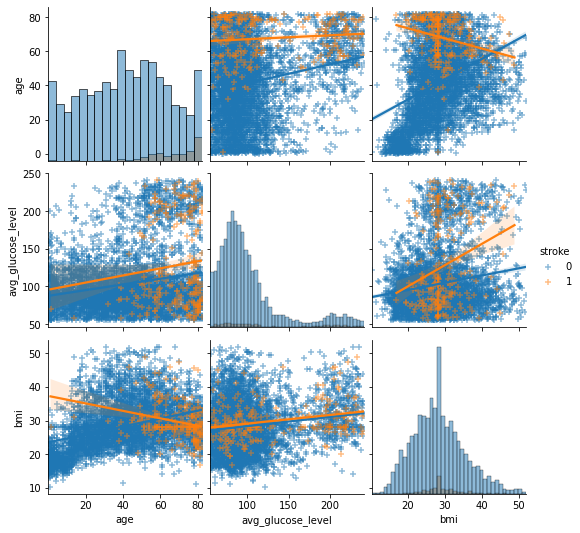

In [15]:
# pairwise scatter plot
input_columns = copy.deepcopy(numerical)
input_columns.append(target)
sns.pairplot(df[input_columns], kind="reg", hue=target, diag_kind="hist",
            plot_kws={"scatter_kws": {"alpha": 0.5}}, markers="+")
plt.show()

##### Cluster analysis of numerical features using k-means
We construct a n-dimensional plane where n is the number of numerical features we have and try to
find 2 clusters, then calculate the density of target in each cluster.

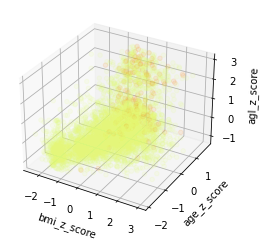

In [16]:
ax = plt.axes(projection='3d')
xline = df["bmi_z_score"]
yline = df["age_z_score"]
zline = df["agl_z_score"]
cline = df[target]
ax.scatter3D(xline, yline, zline, c=cline, cmap='Wistia', alpha=0.1)
ax.set_xlabel("bmi_z_score")
ax.set_ylabel("age_z_score")
ax.set_zlabel("agl_z_score")
plt.show()

% of people with stroke in group 1: 0.32858707557502737
% of people with stroke in group 2: 7.336272040302267


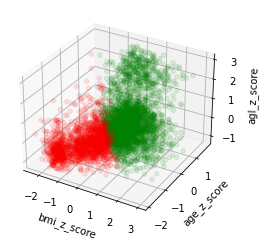

In [17]:
k = 2
df_kmeans = df[["bmi_z_score", "age_z_score", "agl_z_score", target]]
df_kmeans = df_kmeans.rename(columns={"bmi_z_score": "x", "age_z_score": "y", "agl_z_score": "z"})
np.random.choice(df_kmeans["x"])
centroids = {
    i+1: [np.random.choice(df_kmeans["x"]),
          np.random.choice(df_kmeans["y"]),
          np.random.choice(df_kmeans["z"])]
    for i in range(k)
}
colmap = {1: 'r', 2: 'g', 3: 'b'}

def assignment(_df, _centroids):
    for i in _centroids.keys():
        _df['distance_from_{}'.format(i)] = (
            np.sqrt(
                (_df["x"] - _centroids[i][0]) ** 2
                + (_df["y"] - _centroids[i][1]) ** 2
            )
        )
    centroid_distance_cols = ['distance_from_{}'.format(i) for i in _centroids.keys()]
    _df['closest'] = _df.loc[:, centroid_distance_cols].idxmin(axis=1)
    _df['closest'] = _df['closest'].map(lambda x: int(x.lstrip('distance_from_')))
    _df['color'] = _df['closest'].map(lambda x: colmap[x])
    return _df

df_kmeans = assignment(df_kmeans, centroids)

def update(_k):
    for i in centroids.keys():
        centroids[i][0] = np.mean(df_kmeans[df_kmeans['closest'] == i]['x'])
        centroids[i][1] = np.mean(df_kmeans[df_kmeans['closest'] == i]['y'])
    return _k

centroids = update(centroids)
# Continue until all assigned categories don't change any more
while True:
    closest_centroids = df_kmeans['closest'].copy(deep=True)
    centroids = update(centroids)
    df_kmeans = assignment(df_kmeans, centroids)
    if closest_centroids.equals(df_kmeans['closest']):
        break

ax = plt.axes(projection='3d')
ax.scatter3D(df_kmeans["x"], df_kmeans["y"], df_kmeans["z"], c=df_kmeans["color"], alpha=0.1, cmap="brg")
ax.set_xlabel("bmi_z_score")
ax.set_ylabel("age_z_score")
ax.set_zlabel("agl_z_score")

stroke_1 = len(df_kmeans[(df_kmeans.stroke == 1) & (df_kmeans.closest == 1)]) * 100 \
           / len(df_kmeans[df_kmeans.closest == 1])
stroke_2 = len(df_kmeans[(df_kmeans.stroke == 1) & (df_kmeans.closest == 2)]) * 100 \
           / len(df_kmeans[df_kmeans.closest == 2])
print("% of people with stroke in group 1:", stroke_1)
print("% of people with stroke in group 2:", stroke_2)

##### Observations

1. From the pairwise scatter plot we can see that age is a strong predictor of stroke.
1. We also see that if bmi is above median, then high avg_glucose_level also predicts stroke. We can
   confirm this by doing a cluster analysis later.
1. k-means was able to create clearly beneficial clusters, it was **not** able to predict target
   variable to acceptable degree. This could be because number of positive cases is a degree of
   level lower than negative cases, rendering k-means unsuitable for this analysis, and it could
   also be because we have yet to consider categorical features.

#### Categorical attributes

Female    2925
Male      2076
Other        1
Name: gender, dtype: int64


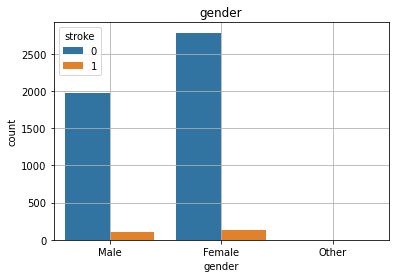

0    4533
1     469
Name: hypertension, dtype: int64


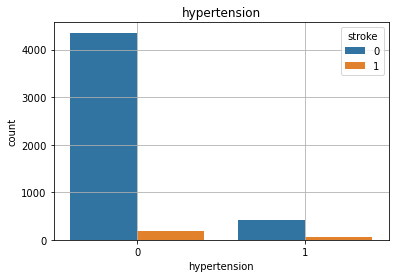

0    4736
1     266
Name: heart_disease, dtype: int64


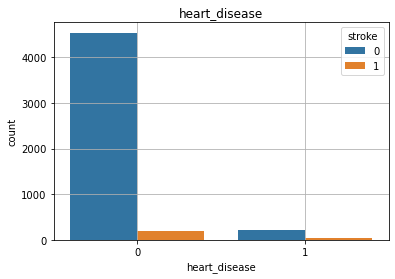

Yes    3260
No     1742
Name: ever_married, dtype: int64


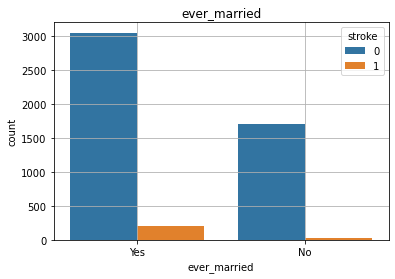

Private          2855
Self-employed     797
children          687
Govt_job          641
Never_worked       22
Name: work_type, dtype: int64


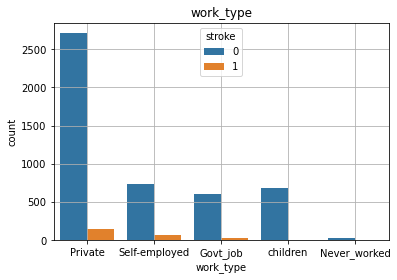

Urban    2542
Rural    2460
Name: Residence_type, dtype: int64


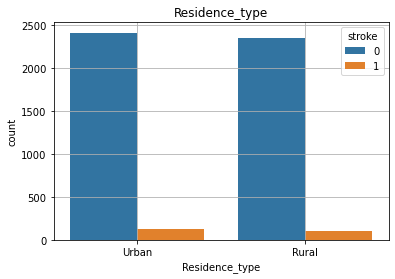

never smoked       1849
Unknown            1524
formerly smoked     862
smokes              767
Name: smoking_status, dtype: int64


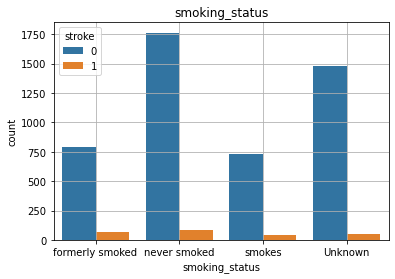

In [18]:
for col in categorical:
    print(df[col].value_counts())
    sns.countplot(x=col, hue=target, data=df)
    plt.title(col)
    plt.grid()
    plt.show()

##### Outlier removal
"Other" gender can be dropped as it is an outlier.

In [19]:
df = df[df.gender != "Other"]
df["gender"].value_counts()

Female    2925
Male      2076
Name: gender, dtype: int64

##### Association rule mining based on Apriori
We perform association rule mining to find out any relation between given categorical features. We
chose **Apriori algorithm** because our dataset is not very big and execution time is within
reasonable limits.

In [20]:
from collections import namedtuple
from itertools import combinations
from itertools import chain


class TransactionManager(object):
    def __init__(self, transactions):
        self.__num_transaction = 0
        self.__items = []
        self.__transaction_index_map = {}

        for transaction in transactions:
            self.add_transaction(transaction)

    def add_transaction(self, transaction):
        for item in transaction:
            if item not in self.__transaction_index_map:
                self.__items.append(item)
                self.__transaction_index_map[item] = set()
            self.__transaction_index_map[item].add(self.__num_transaction)
        self.__num_transaction += 1

    def calc_support(self, items):
        if not items:
            return 1.0

        if not self.num_transaction:
            return 0.0

        sum_indexes = None
        for item in items:
            indexes = self.__transaction_index_map.get(item)
            if indexes is None:
                return 0.0

            if sum_indexes is None:
                sum_indexes = indexes
            else:
                sum_indexes = sum_indexes.intersection(indexes)

        return float(len(sum_indexes)) / self.__num_transaction

    def initial_candidates(self):
        return [frozenset([item]) for item in self.items]

    @property
    def num_transaction(self):
        return self.__num_transaction

    @property
    def items(self):
        return sorted(self.__items)

    @staticmethod
    def create(transactions):
        if isinstance(transactions, TransactionManager):
            return transactions
        return TransactionManager(transactions)


SupportRecord = namedtuple('SupportRecord', ('items', 'support'))
RelationRecord = namedtuple('RelationRecord', SupportRecord._fields + ('ordered_statistics',))
OrderedStatistic = namedtuple('OrderedStatistic', ('items_base', 'items_add', 'confidence', 'lift',))

def create_next_candidates(prev_candidates, length):
    items = sorted(frozenset(chain.from_iterable(prev_candidates)))
    tmp_next_candidates = (frozenset(x) for x in combinations(items, length))
    if length < 3:
        return list(tmp_next_candidates)

    next_candidates = [
        candidate for candidate in tmp_next_candidates
        if all(
            frozenset(x) in prev_candidates
            for x in combinations(candidate, length - 1))
    ]
    return next_candidates

def gen_support_records(transaction_manager, min_support, **kwargs):
    max_length = kwargs.get('max_length')
    _create_next_candidates = kwargs.get('_create_next_candidates', create_next_candidates)
    candidates = transaction_manager.initial_candidates()
    length = 1
    while candidates:
        relations = set()
        for relation_candidate in candidates:
            support = transaction_manager.calc_support(relation_candidate)
            if support < min_support:
                continue
            candidate_set = frozenset(relation_candidate)
            relations.add(candidate_set)
            yield SupportRecord(candidate_set, support)
        length += 1
        if max_length and length > max_length:
            break
        candidates = _create_next_candidates(relations, length)

def gen_ordered_statistics(transaction_manager, record):
    items = record.items
    sorted_items = sorted(items)
    for base_length in range(len(items)):
        for combination_set in combinations(sorted_items, base_length):
            items_base = frozenset(combination_set)
            items_add = frozenset(items.difference(items_base))
            confidence = (
                record.support / transaction_manager.calc_support(items_base))
            lift = confidence / transaction_manager.calc_support(items_add)
            yield OrderedStatistic(
                frozenset(items_base), frozenset(items_add), confidence, lift)


def filter_ordered_statistics(ordered_statistics, **kwargs):
    min_confidence = kwargs.get('min_confidence', 0.0)
    min_lift = kwargs.get('min_lift', 0.0)
    for ordered_statistic in ordered_statistics:
        if ordered_statistic.confidence < min_confidence:
            continue
        if ordered_statistic.lift < min_lift:
            continue
        yield ordered_statistic

def apriori(transactions, **kwargs):
    min_support = kwargs.get('min_support', 0.1)
    min_confidence = kwargs.get('min_confidence', 0.0)
    min_lift = kwargs.get('min_lift', 0.0)
    max_length = kwargs.get('max_length', None)
    if min_support <= 0:
        raise ValueError('minimum support must be > 0')

    _gen_support_records = kwargs.get('_gen_support_records', gen_support_records)
    _gen_ordered_statistics = kwargs.get('_gen_ordered_statistics', gen_ordered_statistics)
    _filter_ordered_statistics = kwargs.get('_filter_ordered_statistics', filter_ordered_statistics)
    transaction_manager = TransactionManager.create(transactions)
    support_records = _gen_support_records(transaction_manager, min_support, max_length=max_length)
    for support_record in support_records:
        ordered_statistics = list(
            _filter_ordered_statistics(
                _gen_ordered_statistics(transaction_manager, support_record),
                min_confidence=min_confidence,
                min_lift=min_lift,
            )
        )
        if not ordered_statistics:
            continue
        yield RelationRecord(
            support_record.items, support_record.support, ordered_statistics)

transactions = list()
for index, row in df.iterrows():
    txn = list()
    for col in categorical:
        txn.append(col + "_" + str(row[col]))
    txn.append(target + "_" + str(row[target]))
    transactions.append(txn)

association_rules = apriori(transactions)
association_results = list(association_rules)

In [21]:
for item in association_results:
    if len(item.items) < 2:
        continue

    if item.support > 0.75:
        print("Rule:", item.items)
        print("Support:", item.support)
        print()

Rule: frozenset({'hypertension_0', 'heart_disease_0'})
Support: 0.8648270345930814

Rule: frozenset({'stroke_0', 'heart_disease_0'})
Support: 0.907618476304739

Rule: frozenset({'hypertension_0', 'stroke_0'})
Support: 0.8704259148170366

Rule: frozenset({'stroke_0', 'hypertension_0', 'heart_disease_0'})
Support: 0.8356328734253149



##### Observations

1. From the association rule mining, we can see that lack of hypertension corresponds to lack of
   heart disease.
1. We can also see that lack of either heart disease or hypertension corresponds negatively to having
   a stroke.
1. Yet, having neither hypertension nor heart disease actually decreases the chance of having a
   stroke. (0.84 < min(0.87, 0.91))

### Model selection - Naive Bayes classifier

We will use Naive Bayes classifier to model our data. For this purpose, we will use normalized
z-score for numerical features, and we will break the categorical features into binary columns thus
converting them to normalized numerical features.

Naive-Bayes is selected among other classifier algorithms purely due to ease of implementation and
as a way to demonstrate that it is not a very good classifier since, as we have seen above, some
features are not entirely independent, whereas Naive-Bayes expects all features to be independent.

In [22]:
for col in categorical:
    for val in df[col].unique():
        df[col + "_" + str(val)] = 0
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,...,work_type_Self-employed,work_type_Govt_job,work_type_children,work_type_Never_worked,Residence_type_Urban,Residence_type_Rural,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,smoking_status_Unknown
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,...,0,0,0,0,0,0,0,0,0,0
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,...,0,0,0,0,0,0,0,0,0,0
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,...,0,0,0,0,0,0,0,0,0,0
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,...,0,0,0,0,0,0,0,0,0,0
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.1,never smoked,...,0,0,0,0,0,0,0,0,0,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,...,0,0,0,0,0,0,0,0,0,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,...,0,0,0,0,0,0,0,0,0,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,...,0,0,0,0,0,0,0,0,0,0


In [23]:
for index, row in df.iterrows():
    for col in categorical:
        df.at[index, col + "_" + str(row[col])] = 1
df = df.drop(columns=numerical)
df = df.drop(columns=categorical)

# Select 80% of data as training data, rest as test data
df_train = df.sample(frac=0.8)
df_test = df.loc[~df.index.isin(df_train.index)]

Accuracy: 0.386


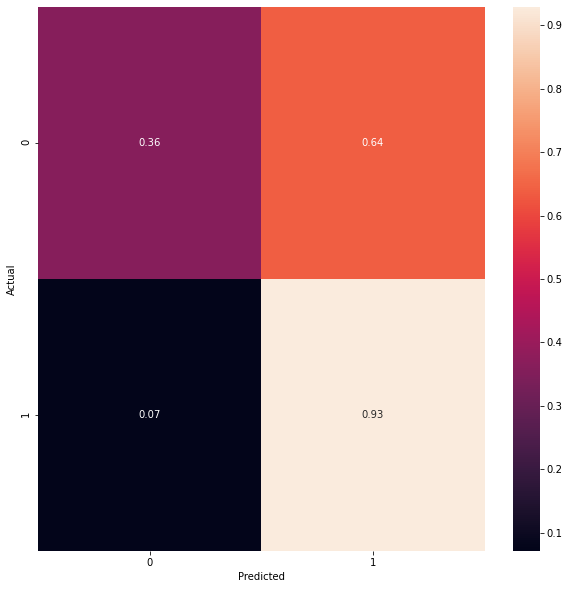

In [24]:
features = list(df_train.columns)
features.remove(target)
X_train = df_train[features]
Y_train = df_train[target]
X_test = df_test[features]
Y_test = df_test[target]
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
classifier = GaussianNB()
classifier.fit(X_train, Y_train)
Y_pred  =  classifier.predict(X_test)
ac = accuracy_score(Y_test, Y_pred)
print("Accuracy:", ac)
cm = confusion_matrix(Y_test, Y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


### Conclusion

From the above confusion matrix we can see that our choice of Naive-Bayes was not a successful as a
classifier. This is expected, as all features were not totally independent.

We can also see that our we are able to detect True Negatives to a high degree. This can be
explained by skewed data where we had a large amount of negatives for target variable but very small
number of positives.

Finally, this nature of data can explain why our is aggressively tuned to detect negatives as seen
from large number of True Negatives as well as False Negatives.